# Jupyter notebook to test run the sun-dic DIC code

This notebook provides a detailed worked example of how to use the sun-dic code.  It provides a typical example that can easily be adjusted as required to solve new problems.  The typical workflow is to first perform the DIC analysis to get all the information that is needed for post-processing.  The resulting displacements and strains are then obtained through post-processing the results from the DIC analysis.

The notebook goes through the following basic steps that is typical for all DIC analyses using sun-dic:
- Load the required libraries
- Load the `settings.ini` file that controls how the DIC analysis is performed
- Perform the DIC analysis
- Post-process the DIC results to obtain the required displacement and strain data
  - This include the raw displacement and strain data
  - Countour plots of displacement and strain results
  - Cut-line plots of displacement and strain results

### Start by loading the required libraries

In [1]:
import numpy as np
import sundic.sundic as sdic
import sundic.post_process as sdpp

### Next load the `settings.ini` file
The file must be called `settings.ini` and must be located in the current working directory (the same directory where this Jupyter notebook file is located).  The `settings.ini` file controls the analysis and is well documented.  Default values are provided and in most cases the default values should provide a good starting point for the analysis.

In [2]:
# Load the settings file
settings = sdic.loadSettings()

# Print the current settings in table form
for key, value in settings.items():
    print( "{0:15} \t {1}".format(key, value) )

DebugLevel      	 1
ImageFolder     	 planar_images
DICType         	 Planar
SubsetSize      	 33
StepSize        	 11
ShapeFunctions  	 Quadratic
ReferenceStrategy 	 Incremental
StartingPoints  	 3
GaussianBlurSize 	 5
GaussianBlurStdDev 	 0.0
DatumImage      	 0
TargetImage     	 1
Increment       	 1
ROI             	 [50, 50, 300, 950]
BackgroundCutoff 	 25
OptimizationAlgorithm 	 IC-LM
MaxIterations   	 25
ConvergenceThreshold 	 0.0001


### Now perform the DIC analysis
The DIC analysis is performed based on the values read from the settings file.  The images to be processes must be located in the **ImageFolder** variable in the settings file.  This folder is relative to the current working diretory (the directory where this Jupyter notebook is located).

The values returned by the **planarDICLocal** function is used in the remaining post-process function calls to obtain the displacement and strain values and to generate graphical representations of that data.

In [3]:
# We wrap the analysis with a timer to see how long it takes
sdic.tic()
nRows, nCols, subSetPoints, coeffs = sdic.planarDICLocal(settings)
sdic.toc()


ROI : 
---------------------------------
  XStart  = 50
  YStart  = 50
  XLength = 300
  YLength = 950

Subset Information : 
---------------------------------
  Number of subsets defined :2100

Image Pair Information :
---------------------------------
  Number of image pairs:  1

Starting IC Optimization for Image Pair: 0
---------------------------------
  Subset 0 of 2100: ID 261 # Iteration 10
  Subset 100 of 2100: ID 339 # Iteration 13
  Subset 200 of 2100: ID 1352 # Iteration 11
  Subset 300 of 2100: ID 18 # Iteration 11
  Subset 400 of 2100: ID 278 # Iteration 11
  Subset 500 of 2100: ID 701 # Iteration 13
  Subset 600 of 2100: ID 1526 # Iteration 12
  Subset 700 of 2100: ID 621 # Iteration 11
  Subset 800 of 2100: ID 1458 # Iteration 12
  Subset 900 of 2100: ID 459 # Iteration 11
  Subset 1000 of 2100: ID 302 # Iteration 10
  Subset 1100 of 2100: ID 482 # Iteration 11
  Subset 1200 of 2100: ID 404 # Iteration 11
  Subset 1300 of 2100: ID 998 # Iteration 10
  Subset 1400 of 21

## Start with post-processing
We will first investigate the displacement data, then the strain data.  Note that the same same **settings** variable used in the analysis above is passed to these functions, with the results obtained from the analysis.

## First the displacement data
The displacemen data is returned as a numpy array with the following columns

| X Coord | Y Coord | Z Coord | X Disp | Y Disp | Z Disp | Disp Magnitude |
|:------- |:------- |:------- |:------ |:------ |:------ |:-------------- |

Missing data points have displacement values of NaN and can thus be easily filtered.  The displacement data can be smoothed using a Savitsky Golay operation by specifying the **smoothWindow** and optionally the **smoothOrder** variables.  All variables for the function are described below in the code.

In [4]:
# Get the displacements
# ------------------------------------------------------------------
# Parameters:
# -----------
# - settings    : the settings dictionary used in the analysis
# - nRows       : the number of rows in the subset grid 
#                 (returned by the planarDICLocal function)
# - nCols       : the number of columns in the subset grid 
#                 (returned by the planarDICLocal function)
# - subSetPoints: the subset grid points
#                 (returned by the planarDICLocal function)
# - coeffs      : the coefficients for the subset grid points
#                 (returned by the planarDICLocal function)
# - smoothWindow: the size of the smoothing window - this is the 
#                 number of surrounding subSets to consider in 
#                 the smoothing (0 = no smoothing)
# - smoothOrder : the order of the smoothing polynomial 
#                 (default is 2)
#
# Returns:
# --------
# - results: the displacement results with the columns as outlined 
#            above
# ------------------------------------------------------------------
results = sdpp.getDisplacements(settings, nRows, nCols, subSetPoints, coeffs, smoothWindow=0)

# An easy way to drop all points that were not found during the analysis 
results = results[~np.isnan(results).any(axis=1)]

# Some basic processing of the results
print('------------------------------------------------------------------')
print('Displacement X Summary')
print('    Min: {0:10.4f}'.format(np.min(results[:, sdpp.Comp.X.value])))
print('    Max: {0:10.4f}'.format(np.max(results[:, sdpp.Comp.X.value])))
print('------------------------------------------------------------------')
print('Displacement Y Summary')
print('    Min: {0:10.4f}'.format(np.min(results[:, sdpp.Comp.Y.value])))
print('    Max: {0:10.4f}'.format(np.max(results[:, sdpp.Comp.Y.value])))
print('------------------------------------------------------------------')
print('Displacement Magnitude Summary')
print('    Min: {0:10.4f}'.format(np.min(results[:, sdpp.Comp.MAG.value])))
print('    Max: {0:10.4f}'.format(np.max(results[:, sdpp.Comp.MAG.value])))
print('------------------------------------------------------------------')

------------------------------------------------------------------
Displacement X Summary
    Min:    -1.3057
    Max:     0.1889
------------------------------------------------------------------
Displacement Y Summary
    Min:   -10.5377
    Max:    -4.3036
------------------------------------------------------------------
Displacement Magnitude Summary
    Min:     4.3044
    Max:    10.5770
------------------------------------------------------------------


### Make a contour plot of the displacement data
This contourplot function has a fairly large number of optional arguments to help customize the output.  Again the results may be smoothed and minimum and maximum values may be set to ignore large outliers that may appear.

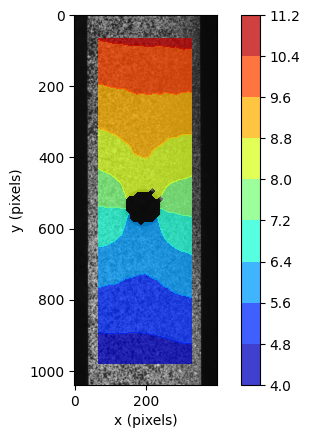

In [5]:
# ------------------------------------------------------------------
# Parameters:
# -----------
# - settings    : the settings dictionary used in the analysis
# - nRows       : the number of rows in the subset grid
#                 (returned by the planarDICLocal function)
# - nCols       : the number of columns in the subset grid
#                 (returned by the planarDICLocal function)
# - subSetPoints: the subset grid points
#                 (returned by the planarDICLocal function)
# - coeffs      : the coefficients for the subset grid points
#                 (returned by the planarDICLocal function)
# - dispComp    : the displacement component to plot
#                 (default is sdpp.Comp.MAG)
# - alpha       : the transparency of the contour plot
#                 (default is 0.75)
# - plotImage   : whether to plot the underlying image
#                 (default is True)
# - showPlot    : whether to show the plot here
#                 (default is True)
# - fileName    : the file name to save the plot to if required
#                 (default is '')
# - smoothWindow: the size of the smoothing window - this is the
#                 number of surrounding subSets to consider in
#                 the smoothing (0 = no smoothing)
# - smoothOrder : the order of the smoothing polynomial
#                 (default is 2)
# - maxValue    : the maximum value to plot
#                 (default is None)
# - minValue    : the minimum value to plot
#                 (default is None)
# ------------------------------------------------------------------
sdpp.plotDispContour(settings, nRows, nCols, subSetPoints, coeffs,
                     dispComp=sdpp.Comp.MAG,
                     alpha=0.75, plotImage=True,
                     showPlot=True, fileName='', smoothWindow=3)

### And some line cuts through the displacement image
The line cut option is useful to get 2D line graphs of a result component by specifying fixed values for either the X or the Y direction.  Multiple cutlines can be considered and the results may be interpolated or not.  If the resutls are interpolated, the exact X or Y values will be used, but gaps in the data will also be filled with interpolated data.  If the interpolation option is set to false, the nearest X or Y values to those specified will be used and gaps will appear for missing data.

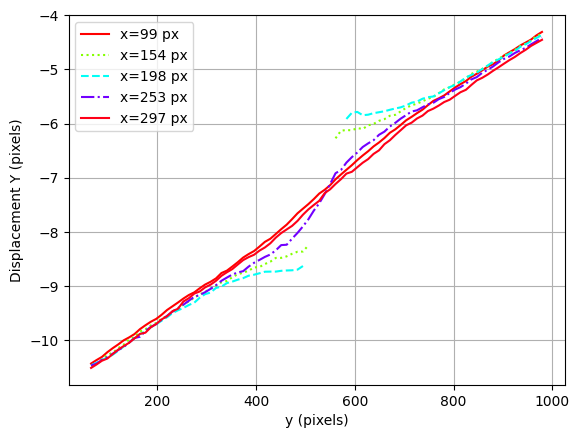

In [6]:
# ------------------------------------------------------------------
# Parameters:
# -----------
# - settings    : the settings dictionary used in the analysis
# - nRows       : the number of rows in the subset grid
#                 (returned by the planarDICLocal function)
# - nCols       : the number of columns in the subset grid
#                 (returned by the planarDICLocal function)
# - subSetPoints: the subset grid points
#                 (returned by the planarDICLocal function)
# - coeffs      : the coefficients for the subset grid points
#                 (returned by the planarDICLocal function)
# - dispComp    : the displacement component to plot
#                 (default is sdpp.Comp.MAG)
# - cutComp     : the component to cut through
#                 (default is sdpp.Comp.X)
# - cutValues   : the values to cut through
#                 (default is None)
# - gridLines   : whether to plot grid lines
#                 (default is True)
# - showPlot    : whether to show the plot here
#                 (default is True)
# - fileName    : the file name to save the plot to if required
#                 (default is '')
# - smoothWindow: the size of the smoothing window - this is the
#                 number of surrounding subSets to consider in
#                 the smoothing (0 = no smoothing)
# - smoothOrder : the order of the smoothing polynomial
#                 (default is 2)
# - interpolate : whether to interpolate the data
#                 (default is False)
# ------------------------------------------------------------------
sdpp.plotDispCutLine(settings, nRows, nCols, subSetPoints, coeffs,
                     dispComp=sdpp.Comp.Y, cutComp=sdpp.Comp.X,
                     cutValues=[100, 150, 200, 250, 300],
                     gridLines=True, showPlot=True,
                     fileName='', smoothWindow=0, interpolate=False)

## Now the strain data
Similar to the displacement data, the raw strain data and a countour and cutline plot will be created for the strain data.

The raw strain data is returned as a numpy array with the following columns

| X Coord | Y Coord | Z Coord | X Strain | Y Strain | XY Strain | VM Strain |
|:------- |:------- |:------- |:-------- |:-------- |:--------- |:--------- |

All strain components are engineering strain.

**Note** the data is always smoothed to calculate the strain data

In [7]:
# Get the strains
# ------------------------------------------------------------------
# Parameters:
# -----------
# - settings    : the settings dictionary used in the analysis
# - nRows       : the number of rows in the subset grid
#                 (returned by the planarDICLocal function)
# - nCols       : the number of columns in the subset grid
#                 (returned by the planarDICLocal function)
# - subSetPoints: the subset grid points
#                 (returned by the planarDICLocal function)
# - coeffs      : the coefficients for the subset grid points
#                 (returned by the planarDICLocal function)
# - smoothWindow: the size of the smoothing window - this is the
#                 number of surrounding subSets to consider in
#                 the smoothing (default is 3)
# - smoothOrder : the order of the smoothing polynomial
#                 (default is 2)
#
# Returns:
# --------
# - results: the strain results with the columns as outlined
#            above
# ------------------------------------------------------------------
results = sdpp.getStrains(
    settings, nRows, nCols, subSetPoints, coeffs)

# Drop any results that are NaN - these are missing points
results = results[~np.isnan(results).any(axis=1)]

# Some basic processing of the results
print('------------------------------------------------------------------')
print('X Strain Summary')
print('    Min: {0:10.4f}'.format(np.min(results[:, sdpp.Comp.X.value])))
print('    Max: {0:10.4f}'.format(np.max(results[:, sdpp.Comp.X.value])))
print('------------------------------------------------------------------')
print('Y Strain Summary')
print('    Min: {0:10.4f}'.format(np.min(results[:, sdpp.Comp.Y.value])))
print('    Max: {0:10.4f}'.format(np.max(results[:, sdpp.Comp.Y.value])))
print('------------------------------------------------------------------')
print('XY Strain Summary')
print('    Min: {0:10.4f}'.format(np.min(results[:, sdpp.Comp.SHEAR.value])))
print('    Max: {0:10.4f}'.format(np.max(results[:, sdpp.Comp.SHEAR.value])))
print('------------------------------------------------------------------')
print('Von Mises Strain Summary')
print('    Min: {0:10.4f}'.format(np.min(results[:, sdpp.Comp.VM.value])))
print('    Max: {0:10.4f}'.format(np.max(results[:, sdpp.Comp.VM.value])))
print('------------------------------------------------------------------')

------------------------------------------------------------------
X Strain Summary
    Min:    -0.1804
    Max:     0.1075
------------------------------------------------------------------
Y Strain Summary
    Min:    -0.0205
    Max:     0.3964
------------------------------------------------------------------
XY Strain Summary
    Min:    -0.0903
    Max:     0.1151
------------------------------------------------------------------
Von Mises Strain Summary
    Min:     0.0061
    Max:     0.3770
------------------------------------------------------------------


### Next a contour plot of the strain data

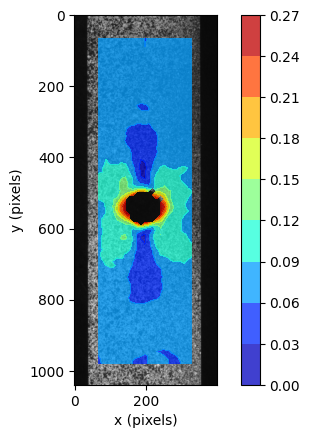

In [8]:
# ------------------------------------------------------------------
# Parameters:
# -----------
# - settings    : the settings dictionary used in the analysis
# - nRows       : the number of rows in the subset grid
#                 (returned by the planarDICLocal function)
# - nCols       : the number of columns in the subset grid
#                 (returned by the planarDICLocal function)
# - subSetPoints: the subset grid points
#                 (returned by the planarDICLocal function)
# - coeffs      : the coefficients for the subset grid points
#                 (returned by the planarDICLocal function)
# - dispComp    : the displacement component to plot
#                 (default is sdpp.Comp.MAG)
# - alpha       : the transparency of the contour plot
#                 (default is 0.75)
# - plotImage   : whether to plot the underlying image
#                 (default is True)
# - showPlot    : whether to show the plot here
#                 (default is True)
# - fileName    : the file name to save the plot to if required
#                 (default is '')
# - smoothWindow: the size of the smoothing window - this is the
#                 number of surrounding subSets to consider in
#                 the smoothing (0 = no smoothing)
# - smoothOrder : the order of the smoothing polynomial
#                 (default is 2)
# - maxValue    : the maximum value to plot
#                 (default is None)
# - minValue    : the minimum value to plot
#                 (default is None)
# ------------------------------------------------------------------
sdpp.plotStrainContour(settings, nRows, nCols, subSetPoints, coeffs,
                       strainComp=sdpp.Comp.VM,
                       alpha=0.75, plotImage=True,
                       showPlot=True, fileName='', smoothWindow=5, maxValue=0.25)

### And some line cuts through the strain image

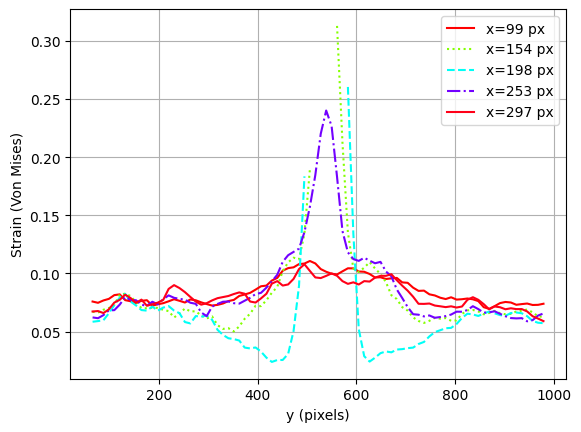

In [9]:
# ------------------------------------------------------------------
# Parameters:
# -----------
# - settings    : the settings dictionary used in the analysis
# - nRows       : the number of rows in the subset grid
#                 (returned by the planarDICLocal function)
# - nCols       : the number of columns in the subset grid
#                 (returned by the planarDICLocal function)
# - subSetPoints: the subset grid points
#                 (returned by the planarDICLocal function)
# - coeffs      : the coefficients for the subset grid points
#                 (returned by the planarDICLocal function)
# - strainComp  : the strain component to plot
#                 (default is sdpp.Comp.VM)
# - cutComp     : the component to cut through
#                 (default is sdpp.Comp.X)
# - cutValues   : the values to cut through
#                 (default is None)
# - gridLines   : whether to plot grid lines
#                 (default is True)
# - showPlot    : whether to show the plot here
#                 (default is True)
# - fileName    : the file name to save the plot to if required
#                 (default is '')
# - smoothWindow: the size of the smoothing window - this is the
#                 number of surrounding subSets to consider in
#                 the smoothing (0 = no smoothing)
# - smoothOrder : the order of the smoothing polynomial
#                 (default is 2)
# - interpolate : whether to interpolate the data
#                 (default is False)
# ------------------------------------------------------------------
sdpp.plotStrainCutLine(settings, nRows, nCols, subSetPoints, coeffs,
                     strainComp=sdpp.Comp.VM, cutComp=sdpp.Comp.X,
                     cutValues=[100, 150, 200, 250, 300],
                     gridLines=True, showPlot=True,
                     fileName='', smoothWindow=5, interpolate=False)